## Детекция изображений

Сегодня на семинаре мы попробуем обучить детекцию. Мы не будем полностью реализовывать архитектуру сети, а возьмем предобученную Faster R-CNN из pytorch и сделаем fine-tuning

Для начала загрузим данные. Мы будем пользоваться датасетом [Penn-Fudan](https://www.cis.upenn.edu/~jshi/ped_html/). Он содержит 170 изображений с разметкой сегментации и детекции. Мы воспользуемся последней

Загрузим данные

In [18]:
! curl https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip > PennFudanPed.zip
! unzip -q PennFudanPed.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.2M  100 51.2M    0     0  21.5M      0  0:00:02  0:00:02 --:--:-- 21.5M
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [19]:
! ls PennFudanPed

added-object-list.txt  Annotation  PedMasks  PNGImages	readme.txt


In [34]:
import torch
import numpy as np

import os
import time
from PIL import Image
from sklearn.metrics import auc

import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [21]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])

        target = {"boxes": boxes, "labels": labels, "image_id": image_id}

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [22]:
def get_transform(train=False):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [23]:
dataset = PennFudanDataset('PennFudanPed/', get_transform())

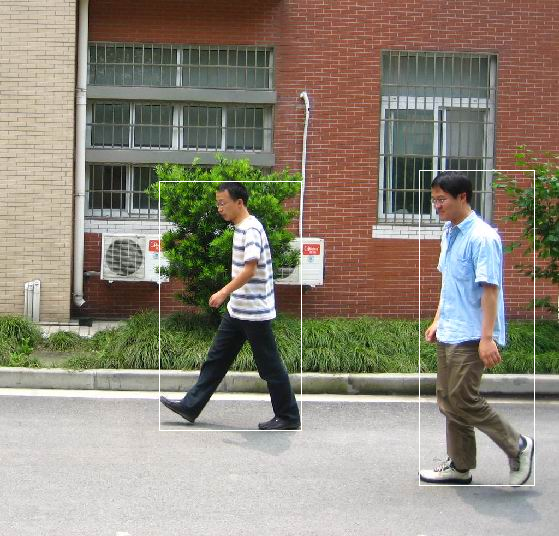

In [24]:
from PIL import ImageDraw

image, labels = next(iter(dataset))

image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
image

Теперь подгрузим модель. Среди моделей детекции в pytorch есть только Faster R-CNN. Так как мы детектим только 2 класса — пешеходов и фон, нужно изменить выходной слой, предсказывающий классы изображений. Для этого в torchvision есть блок FastRCNNPredictor.

Fast R-CNN</h4>
<img src=https://pytorch.org/tutorials/_static/img/tv_tutorial/tv_image03.png>

In [25]:
def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

Теперь давайте напишем подсчет IoU, которая пригодится нам для отбора кандидатов

Intersection over Union</h4>
<img src=https://www.pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png>

In [49]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    inter_x_0 = max(dt_bbox[0], gt_bbox[0])
    inter_x_1 = min(dt_bbox[2], gt_bbox[2])
    inter_y_0 = max(dt_bbox[1], gt_bbox[1])
    inter_y_1 = min(dt_bbox[3], gt_bbox[3])

    intersection = max(inter_x_1 - inter_x_0, 0) * max(inter_y_1 - inter_y_0, 0)

    space_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    space_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    union = space_dt + space_gt - intersection

    return intersection / union

In [29]:
def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # правильные прямоугольники
    gt_bboxes = target_true['boxes'].numpy()
    gt_labels = target_true['labels'].numpy()

    # предсказания модели
    dt_bboxes = target_pred['boxes'].numpy()
    dt_labels = target_pred['labels'].numpy()
    dt_scores = target_pred['scores'].numpy()

    results = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {'score': dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        
        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5 
            detection_result_dict['TP'] = 1
            # удаляем эти прямоугольники из данных, чтобы больше не матчить с ними
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict['TP'] = 0

        results.append(detection_result_dict)

    # возвращаем результат, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results

In [30]:
def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true['labels'].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k['score'], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]['TP'] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]['TP'] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]['TP']) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

In [31]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    n = 0
    global_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(global_loss / n, 2)))

    return global_loss


def train(model, num_epochs, train_loader, test_loader, optimizer, device):
    for epoch in range(num_epochs):
        print("epoch {}/{}..".format(epoch, num_epochs))
        start = time.time()
        train_one_epoch(model, optimizer, train_loader, device)
        mAP = evaluate(model, test_loader, device=device)
        end = time.time()

        print("epoch {} done in {}s".format(epoch, round(end - start, 2)))
        print("mAP after epoch {} is {}:".format(epoch, round(mAP, 3)))

In [32]:
def collate_fn(batch):
    return tuple(zip(*batch))

Посмотрим что делает функция `collate_fn`.

Посмотрим, что будет без нее.

In [36]:
# Пусть мы имеем следующий датасет 
# df = [(image_1, target_1), ..., (image_ell, target_ell)], причем картинки разного размера

df = [([2, 3, 4], 5), ([3], 2), ([5, 6], 8), ([9], 0), ([1, 2, 3], 4)]
pseudo_dataloader = torch.utils.data.DataLoader(df, batch_size=2)

for item in pseudo_dataloader:
  print(item)

RuntimeError: ignored

А теперь с ней. То есть `collate_fn` — это функция, принимающаяся к каждому элементу датасета, с помощью которой формируется по заданным условиям батч. На пример у нас батч формируется следующим образом: $((image_1, ..., image_m), (target_1, ..., target_m))$, где $m$ — число элементов в батче.

In [37]:
df = [([2, 3, 4], 5), ([3], 2), ([5, 6], 8), ([9], 0), ([1, 2, 3], 4)]
pseudo_dataloader = torch.utils.data.DataLoader(df, batch_size=2, collate_fn=collate_fn)

for item in pseudo_dataloader:
  print(item)

(([2, 3, 4], [3]), (5, 2))
(([5, 6], [9]), (8, 0))
(([1, 2, 3],), (4,))


In [47]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

dataset = PennFudanDataset('PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset, indices[-50:])
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)


In [50]:
num_epochs = 5

model = get_detection_model(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
train(model, num_epochs, data_loader, data_loader_test, optimizer, device)

epoch 0/5..
Loss value after 10 batches is 0.59
Loss value after 20 batches is 0.48
Loss value after 30 batches is 0.39
Loss value after 40 batches is 0.34
Loss value after 50 batches is 0.3
Loss value after 60 batches is 0.28
epoch 0 done in 23.86s
mAP after epoch 0 is 0.955:
epoch 1/5..
Loss value after 10 batches is 0.13
Loss value after 20 batches is 0.14
Loss value after 30 batches is 0.13
Loss value after 40 batches is 0.13
Loss value after 50 batches is 0.12
Loss value after 60 batches is 0.12
epoch 1 done in 23.95s
mAP after epoch 1 is 0.969:
epoch 2/5..
Loss value after 10 batches is 0.1
Loss value after 20 batches is 0.1
Loss value after 30 batches is 0.1
Loss value after 40 batches is 0.1
Loss value after 50 batches is 0.1
Loss value after 60 batches is 0.1
epoch 2 done in 24.15s
mAP after epoch 2 is 0.969:
epoch 3/5..
Loss value after 10 batches is 0.08
Loss value after 20 batches is 0.08
Loss value after 30 batches is 0.08
Loss value after 40 batches is 0.08
Loss value aft

Давайте посмотрим, как наша модель научилась выделять людей

In [56]:
idx = np.random.randint(0, len(dataset_test))
image, labels = dataset_test[idx]
pred = model(image.unsqueeze(0).to(device))[0]

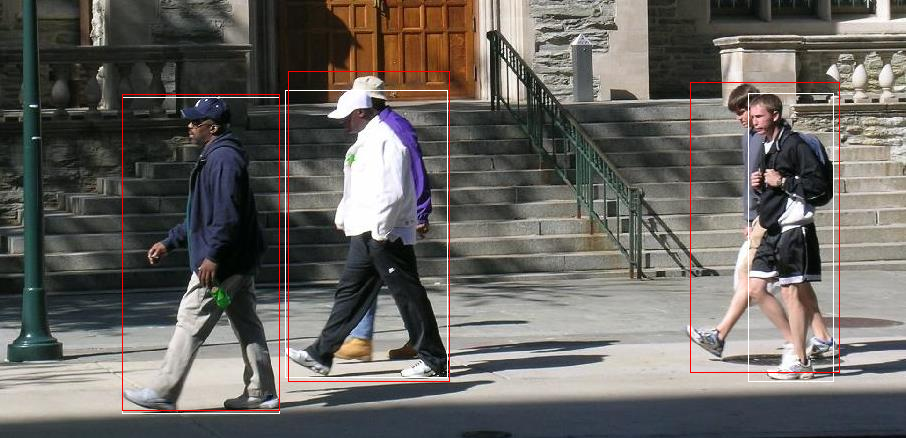

In [57]:
image = T.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image